In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sage import MarginalImputer, PermutationEstimator

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

from oob_methods import compute_oob_fis
from data_generator import generate_gaussian_causal_network

In [2]:
# We will first consider the following DAG (arrows are directed downwards):
#           x_0
#            |
#       x_1 x_2
#    x_3  \  | \
#      \   \ |  \
#       x_4 x_5  x_6
#         \ /
#         x_7    x_8
# x_5 will be the target. Its Markov Blanket is (x_1, x_2, x_4, x_7) so we want these
# features to receive the highest importance.
# The only non zero weights will be w_2,0 ; w_4,3 ; w_5,1 ; w_5,2 ; w_6,2 ; w_7,4 ; w_7,5
# We choose arbitrary values for the weight, bias and variance terms and therefore define:

#             x0  x1 x2 x3 x4 x5  x6 x7 x8
b = np.array([1, -1, 1, 2, 1, 2, -2, 3, 5])

#             x0   x1   x2   x3   x4   x5   x6   x7   x8
v = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 0.1, 1.0, 1.0, 1.0])

w = np.array(
    [
        # x0   x1   x2   x3   x4   x5   x6   x7   x8
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x0
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x1
        [2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x2
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x3
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x4
        [0.0, 1.0, -1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x5
        [0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x6
        [0.0, 0.0, 0.0, 0.0, 1.5, -1., 0.0, 0.0, 0.0],  # x7
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x8
    ]
)

n_feature = len(b) - 1
idx_target = 5
idx_features = [i for i in range(n_feature + 1) if i != idx_target]
rng = np.random.RandomState(42)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

def run_asymptotic_analysis(sample_sizes, n_simulations=50, test_size=500, n_estimators=50):
    """
    Run feature importance analysis across different sample sizes.
    
    Parameters:
    -----------
    sample_sizes : list
        List of training sample sizes to test
    n_simulations : int
        Number of simulations per sample size
    test_size : int
        Fixed test set size
    n_estimators : int
        Number of trees in random forest
    
    Returns:
    --------
    dict : Results organized by sample size and method
    """
    results = {
        'sample_sizes': sample_sizes,
        'mdi': {},
        'ufi': {},
        'mdi_oob': {},
        'naive_oob': {},
        'j_score': {},
        'sage': {},
        'permut': {},
        'loss_improvement': {}  # Model loss improvement over dummy
    }
    
    for train_size in sample_sizes:
        print(f"Processing sample size: {train_size}")
        
        # Initialize storage for this sample size
        results['mdi'][train_size] = []
        results['ufi'][train_size] = []
        results['mdi_oob'][train_size] = []
        results['naive_oob'][train_size] = []
        results['j_score'][train_size] = []
        results['sage'][train_size] = []
        results['permut'][train_size] = []
        results['loss_improvement'][train_size] = []
        
        for sim in range(n_simulations):
            # Generate data
            Xy, mu, Sigma = generate_gaussian_causal_network(
                n_sample=train_size + test_size,
                b=b,
                v=v,
                w=w,
                random_state=rng,
            )
            X, y = Xy[:, idx_features], Xy[:, idx_target]
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, shuffle=True, random_state=rng
            )
            
            # Train models
            regressor = RandomForestRegressor(
                n_estimators=n_estimators,
                oob_score=True,
                min_samples_leaf=5,
                n_jobs=-1,
                random_state=rng,
            ).fit(X_train, y_train)
            
            dummy = DummyRegressor(strategy="mean").fit(X_train, y_train)
            
            # Compute loss improvement
            model_loss = mean_squared_error(y_test, regressor.predict(X_test))
            dummy_loss = mean_squared_error(y_test, dummy.predict(X_test))
            loss_improvement = dummy_loss - model_loss
            results['loss_improvement'][train_size].append(loss_improvement)
            
            # Compute feature importances
            results['mdi'][train_size].append(regressor._unnormalized_feature_importances)
            
            feature_importance_res = compute_oob_fis(
                regressor,
                X_train,
                y_train,
                mean_squared_error,
                ["UFI", "MDI-oob", "j-score", "naive-oob"],
            )
            
            results['ufi'][train_size].append(feature_importance_res["UFI"])
            results['mdi_oob'][train_size].append(feature_importance_res["MDI-oob"])
            results['j_score'][train_size].append(feature_importance_res["j-score"])
            results['naive_oob'][train_size].append(feature_importance_res["naive-oob"])
            
            # SAGE values
            imputer = MarginalImputer(regressor, X_test)
            estimator = PermutationEstimator(imputer, "mse", random_state=rng)
            results['sage'][train_size].append(estimator(X_test, y_test, thresh=0.1, bar=False).values)
            
            # Permutation importance
            results['permut'][train_size].append(
                permutation_importance(regressor, X_test, y_test, n_repeats=5, random_state=rng).importances_mean
            )
    
    return results

def plot_asymptotic_behavior(results, figsize=(20, 15)):
    """
    Create comprehensive plots showing asymptotic behavior.
    
    Parameters:
    -----------
    results : dict
        Results from run_asymptotic_analysis
    figsize : tuple
        Figure size
    
    Returns:
    --------
    tuple : (fig1, fig2) - Individual features plot and summary plot
    """
    sample_sizes = results['sample_sizes']
    
    markov_features = [1, 2, 4, 7]
    
    methods = ['mdi', 'ufi', 'mdi_oob', 'naive_oob', 'j_score', 'sage', 'permut']
    method_names = ['MDI', 'UFI', 'MDI-OOB', 'Naive-OOB', 'J-Score', 'SAGE', 'Permutation']
    
    # Create figure for individual features
    fig1, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.flatten()
    
    # Plot each feature's evolution
    for feat_idx, original_feat in enumerate([0, 1, 2, 3, 4, 6, 7, 8]):
        ax = axes[feat_idx]
        
        for method, method_name in zip(methods, method_names):
            means = []
            lower_bounds = []
            upper_bounds = []
            
            for sample_size in sample_sizes:
                # Extract importance values for this feature across simulations
                feature_importances = []
                for sim_result in results[method][sample_size]:
                    feature_importances.append(sim_result[feat_idx])
                
                mean_val = np.mean(feature_importances)
                std_val = np.std(feature_importances)
                
                means.append(mean_val)
                lower_bounds.append(mean_val - std_val)
                upper_bounds.append(mean_val + std_val)
            
            # Plot with shaded zones
            color = None
            if original_feat in markov_features:
                alpha = 0.8
            else:
                alpha = 0.6
            
            line = ax.plot(sample_sizes, means, label=method_name, marker='o', markersize=4, alpha=alpha)[0]
            ax.fill_between(sample_sizes, lower_bounds, upper_bounds, alpha=0.2, color=line.get_color())
        
        ax.set_title(f'Feature {original_feat}' + 
                    (' (Markov Blanket)' if original_feat in markov_features else ''))
        ax.set_xlabel('Training Sample Size (log scale)')
        ax.set_ylabel('Importance Score')
        ax.set_xscale('log')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        
        # Add horizontal line at zero
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Hide unused subplot
    axes[8].set_visible(False)
    
    plt.tight_layout()
    
    # Create figure for summary analysis
    fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Sum of importance scores
    for method, method_name in zip(methods, method_names):
        sum_means = []
        sum_lower = []
        sum_upper = []
        
        for sample_size in sample_sizes:
            # Sum importance across all features for each simulation
            sum_importances = []
            for sim_result in results[method][sample_size]:
                sum_importances.append(np.sum(sim_result))
            
            mean_val = np.mean(sum_importances)
            std_val = np.std(sum_importances)
            
            sum_means.append(mean_val)
            sum_lower.append(mean_val - std_val)
            sum_upper.append(mean_val + std_val)
        
        line = ax1.plot(sample_sizes, sum_means, label=method_name, marker='o', markersize=4)[0]
        ax1.fill_between(sample_sizes, sum_lower, sum_upper, alpha=0.2, color=line.get_color())
    
    ax1.set_title('Sum of Feature Importances vs Sample Size')
    ax1.set_xlabel('Training Sample Size (log scale)')
    ax1.set_ylabel('Sum of Importance Scores')
    ax1.set_xscale('log')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Loss improvement
    loss_means = []
    loss_lower = []
    loss_upper = []
    
    for sample_size in sample_sizes:
        loss_improvements = results['loss_improvement'][sample_size]
        mean_val = np.mean(loss_improvements)
        std_val = np.std(loss_improvements)
        
        loss_means.append(mean_val)
        loss_lower.append(mean_val - std_val)
        loss_upper.append(mean_val + std_val)
    
    ax2.plot(sample_sizes, loss_means, marker='o', color='green', markersize=6, linewidth=2)
    ax2.fill_between(sample_sizes, loss_lower, loss_upper, alpha=0.3, color='green')
    ax2.set_title('Model Loss Improvement vs Sample Size')
    ax2.set_xlabel('Training Sample Size (log scale)')
    ax2.set_ylabel('Loss Improvement (Dummy MSE - Model MSE)')
    ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: SAGE sum vs Loss improvement (should be equal)
    sage_means = []
    sage_lower = []
    sage_upper = []
    
    for sample_size in sample_sizes:
        sums = []
        for sim_result in results['sage'][sample_size]:
            sums.append(np.sum(sim_result))
        
        mean_val = np.mean(sums)
        std_val = np.std(sums)
        
        sage_means.append(mean_val)
        sage_lower.append(mean_val - std_val)
        sage_upper.append(mean_val + std_val)
    
    ax3.plot(sample_sizes, sage_means, 'bo-', label='SAGE Sum', markersize=6)
    ax3.fill_between(sample_sizes, sage_lower, sage_upper, alpha=0.3, color='blue')
    
    ax3.plot(sample_sizes, loss_means, 'ro-', label='Loss Improvement', markersize=6)
    ax3.fill_between(sample_sizes, loss_lower, loss_upper, alpha=0.3, color='red')
    
    ax3.set_title('SAGE Decomposition Property:\nSAGE Sum vs Loss Improvement')
    ax3.set_xlabel('Training Sample Size (log scale)')
    ax3.set_ylabel('Value')
    ax3.set_xscale('log')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Plot 4: Relative difference between SAGE sum and loss improvement
    relative_diff = []
    for i, sample_size in enumerate(sample_sizes):
        if loss_means[i] != 0:
            diff = abs(sage_means[i] - loss_means[i]) / abs(loss_means[i])
            relative_diff.append(diff)
        else:
            relative_diff.append(0)
    
    ax4.plot(sample_sizes, relative_diff, 'go-', markersize=6, linewidth=2)
    ax4.set_title('SAGE Decomposition Error:\nRelative Difference |SAGE_sum - Loss_improvement| / Loss_improvement')
    ax4.set_xlabel('Training Sample Size (log scale)')
    ax4.set_ylabel('Relative Error')
    ax4.set_xscale('log')
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')
    
    plt.tight_layout()
    
    return fig1, fig2

def create_convergence_summary_table(results):
    """
    Create a summary table showing convergence behavior.
    """
    sample_sizes = results['sample_sizes']
    methods = ['mdi', 'ufi', 'mdi_oob', 'naive_oob', 'j_score', 'sage', 'permut']
    method_names = ['MDI', 'UFI', 'MDI-OOB', 'Naive-OOB', 'J-Score', 'SAGE', 'Permutation']
    
    print("CONVERGENCE ANALYSIS")
    print("=" * 100)
    print("Mean importance scores by sample size (Markov Blanket features: 1,2,4,7)")
    print("-" * 100)
    
    for method, method_name in zip(methods, method_names):
        print(f"\n{method_name}:")
        print("Sample Size | F0      | F1      | F2      | F3      | F4      | F6      | F7      | F8     | Sum")
        print("------------|---------|---------|---------|---------|---------|---------|---------|--------|-----")
        
        for sample_size in sample_sizes:
            # Calculate means across simulations
            feature_means = []
            for feat_idx in range(8):  # 8 features in importance array
                importances = [sim_result[feat_idx] for sim_result in results[method][sample_size]]
                feature_means.append(np.mean(importances))
            
            sum_mean = np.sum(feature_means)
            
            # Format output
            size_str = f"{sample_size:11d}"
            feat_str = " | ".join([f"{val:7.4f}" for val in feature_means])
            sum_str = f"{sum_mean:7.4f}"
            
            print(f"{size_str} | {feat_str} | {sum_str}")
    
    # SAGE decomposition analysis
    print(f"\n" + "=" * 100)
    print("SAGE DECOMPOSITION ANALYSIS")
    print("-" * 50)
    print("Sample Size | Loss Improve | SAGE Sum | Abs Diff | Rel Error")
    print("------------|--------------|----------|----------|----------")
    
    for sample_size in sample_sizes:
        # Loss improvement
        loss_improvements = results['loss_improvement'][sample_size]
        loss_mean = np.mean(loss_improvements)
        
        # SAGE sum
        sage_sums = [np.sum(sim_result) for sim_result in results['sage'][sample_size]]
        sage_mean = np.mean(sage_sums)
        
        # Differences
        abs_diff = abs(sage_mean - loss_mean)
        rel_error = abs_diff / abs(loss_mean) if loss_mean != 0 else float('inf')
        
        print(f"{sample_size:11d} | {loss_mean:12.6f} | {sage_mean:8.6f} | {abs_diff:8.6f} | {rel_error:8.4f}")

def plot_markov_blanket_focus(results, figsize=(16, 10)):
    """
    Create focused plots on Markov blanket features vs others.
    """
    sample_sizes = results['sample_sizes']
    methods = ['mdi', 'ufi', 'mdi_oob', 'naive_oob', 'j_score', 'sage', 'permut']
    method_names = ['MDI', 'UFI', 'MDI-OOB', 'Naive-OOB', 'J-Score', 'SAGE', 'Permutation']
    
    # Markov blanket features in importance indices: [1, 2, 4, 6] (original [1,2,4,7])
    markov_indices = [1, 2, 4, 6]
    non_markov_indices = [0, 3, 5, 7]  # original features [0, 3, 6, 8]
    
    fig, axes = plt.subplots(2, 4, figsize=figsize)
    
    for i, (method, method_name) in enumerate(zip(methods, method_names)):
        row = i // 4
        col = i % 4
        
        if row >= 2:  # Only 7 methods, 2 rows of 4
            break
            
        ax = axes[row, col]
        
        # Calculate mean importance for Markov blanket vs non-Markov blanket features
        mb_means = []
        non_mb_means = []
        mb_lower = []
        mb_upper = []
        non_mb_lower = []
        non_mb_upper = []
        
        for sample_size in sample_sizes:
            # Markov blanket features
            mb_importances = []
            for sim_result in results[method][sample_size]:
                mb_importance = np.sum([sim_result[idx] for idx in markov_indices])
                mb_importances.append(mb_importance)
            
            mb_mean = np.mean(mb_importances)
            mb_std = np.std(mb_importances)
            mb_means.append(mb_mean)
            mb_lower.append(mb_mean - mb_std)
            mb_upper.append(mb_mean + mb_std)
            
            # Non-Markov blanket features  
            non_mb_importances = []
            for sim_result in results[method][sample_size]:
                non_mb_importance = np.sum([sim_result[idx] for idx in non_markov_indices])
                non_mb_importances.append(non_mb_importance)
            
            non_mb_mean = np.mean(non_mb_importances)
            non_mb_std = np.std(non_mb_importances)
            non_mb_means.append(non_mb_mean)
            non_mb_lower.append(non_mb_mean - non_mb_std)
            non_mb_upper.append(non_mb_mean + non_mb_std)
        
        # Plot both with shaded zones
        ax.plot(sample_sizes, mb_means, color='red', marker='o', label='Markov Blanket (1,2,4,7)')
        ax.fill_between(sample_sizes, mb_lower, mb_upper, alpha=0.3, color='red')
        
        ax.plot(sample_sizes, non_mb_means, color='blue', marker='s', label='Non-MB (0,3,6,8)')
        ax.fill_between(sample_sizes, non_mb_lower, non_mb_upper, alpha=0.3, color='blue')
        
        ax.set_title(f'{method_name}')
        ax.set_xlabel('Training Sample Size (log scale)')
        ax.set_ylabel('Sum of Importance Scores')
        ax.set_xscale('log')
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    # Hide unused subplot
    axes[1, 3].set_visible(False)
    
    plt.suptitle('Markov Blanket vs Non-Markov Blanket Features\nSum of Importance Scores', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return fig


In [4]:
print("Starting asymptotic analysis...")

# Define sample sizes to test
sample_sizes = [100, 200, 400, 800, 1600, 3200]  # Doubling sample sizes

# Run the analysis
results = run_asymptotic_analysis(
    sample_sizes=sample_sizes,
    n_simulations=30,  # Reduced for faster computation
    test_size=500,
    n_estimators=50
)

Starting asymptotic analysis...
Processing sample size: 100
Processing sample size: 200
Processing sample size: 400
Processing sample size: 800
Processing sample size: 1600
Processing sample size: 3200


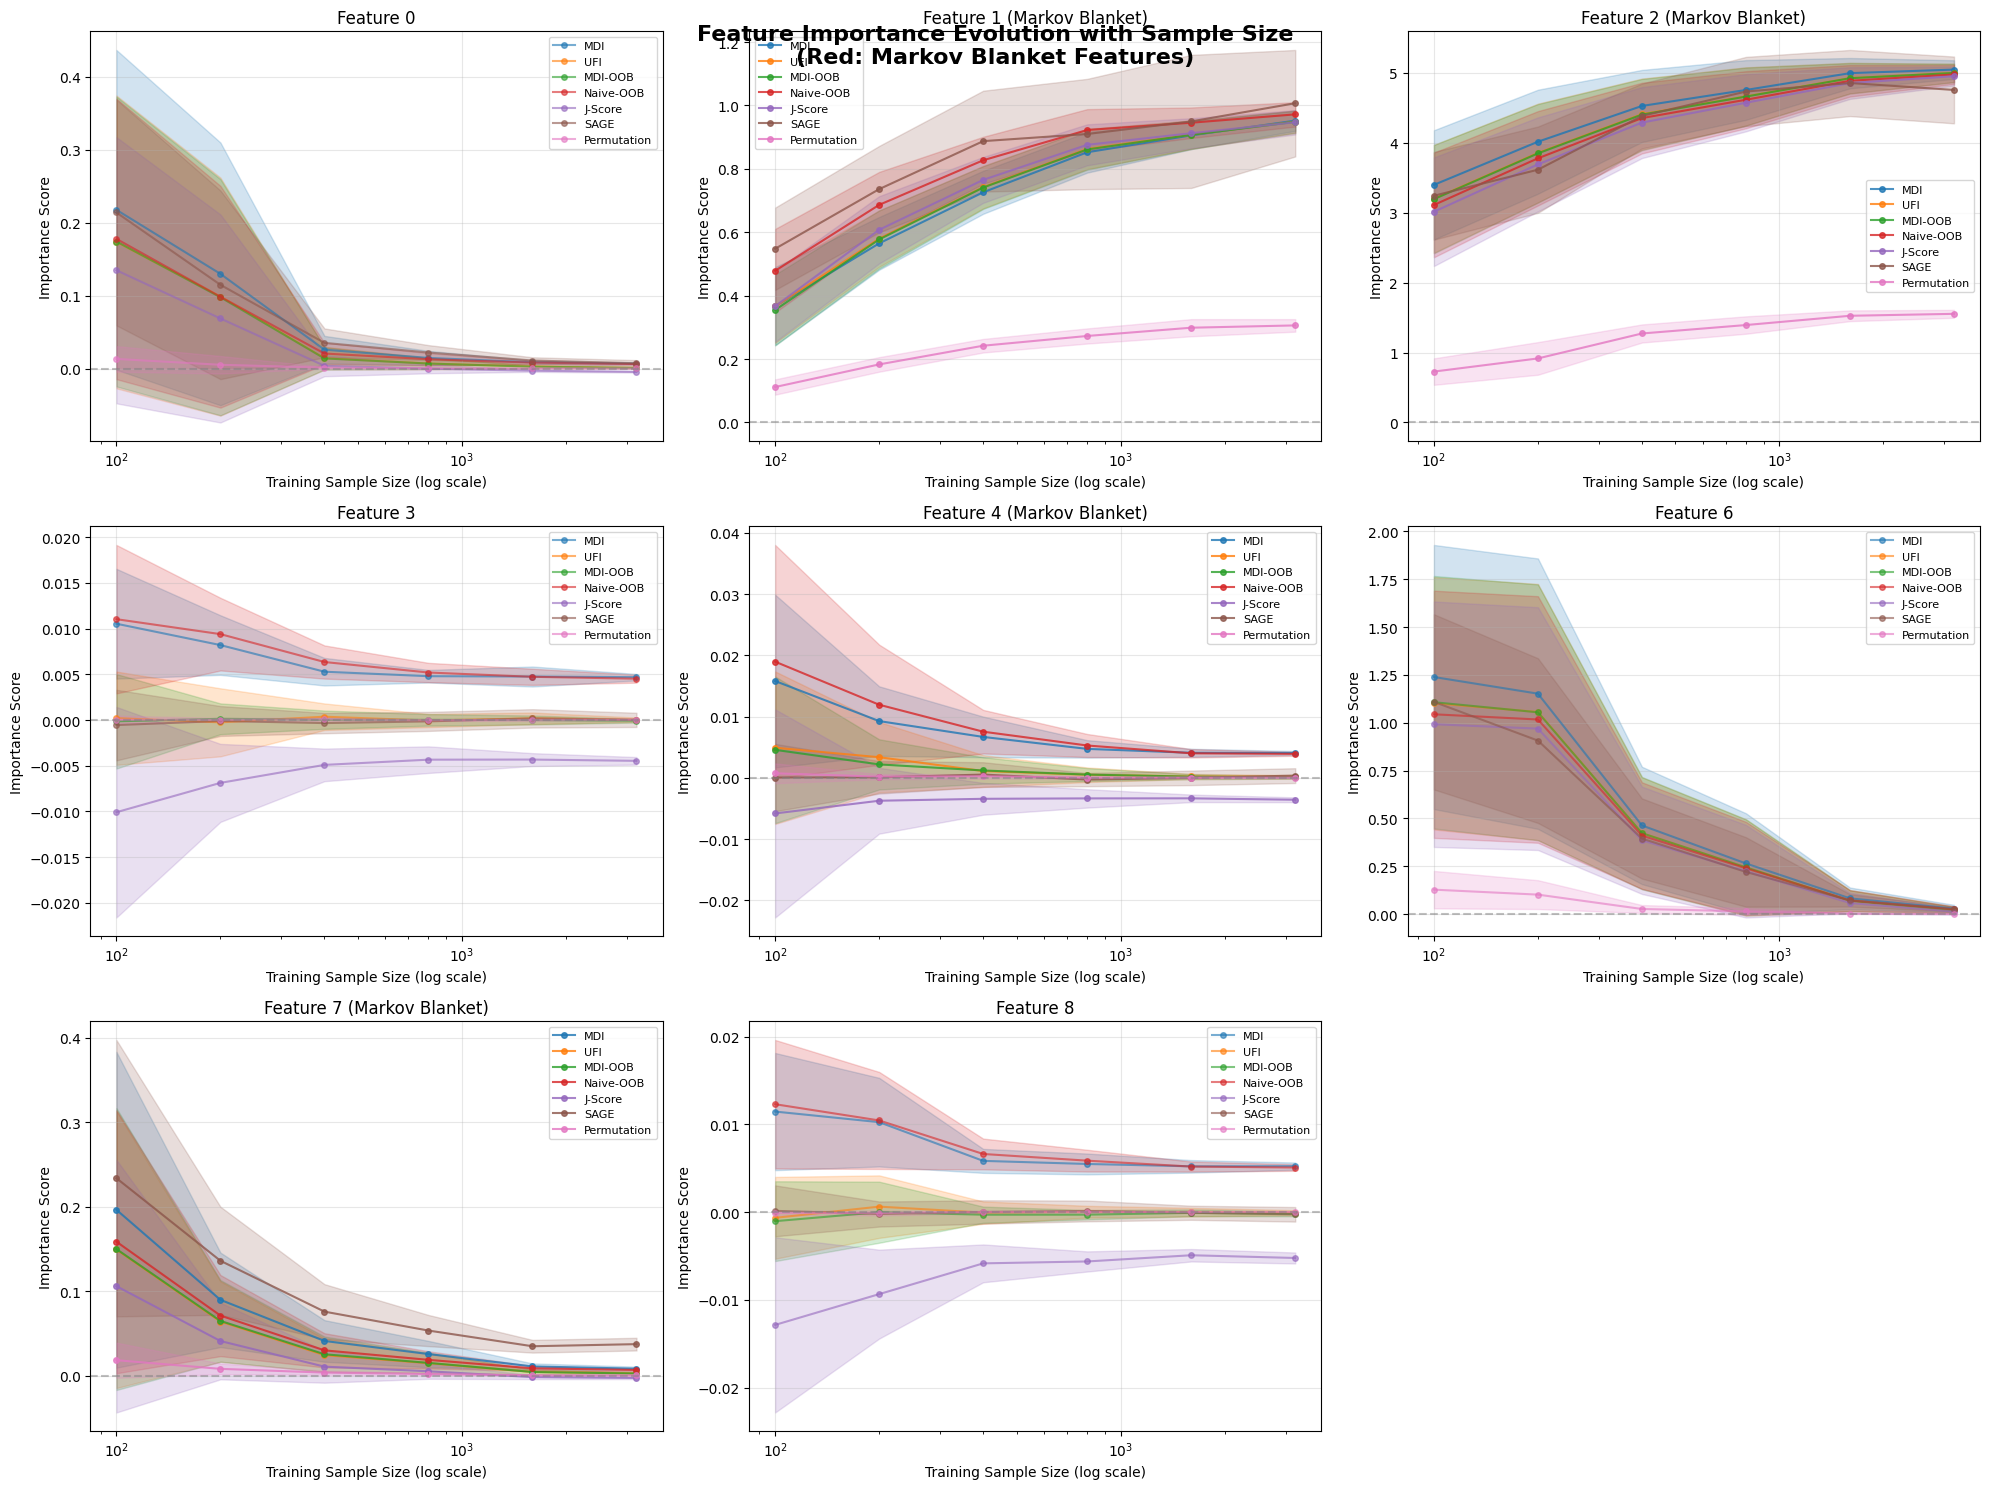

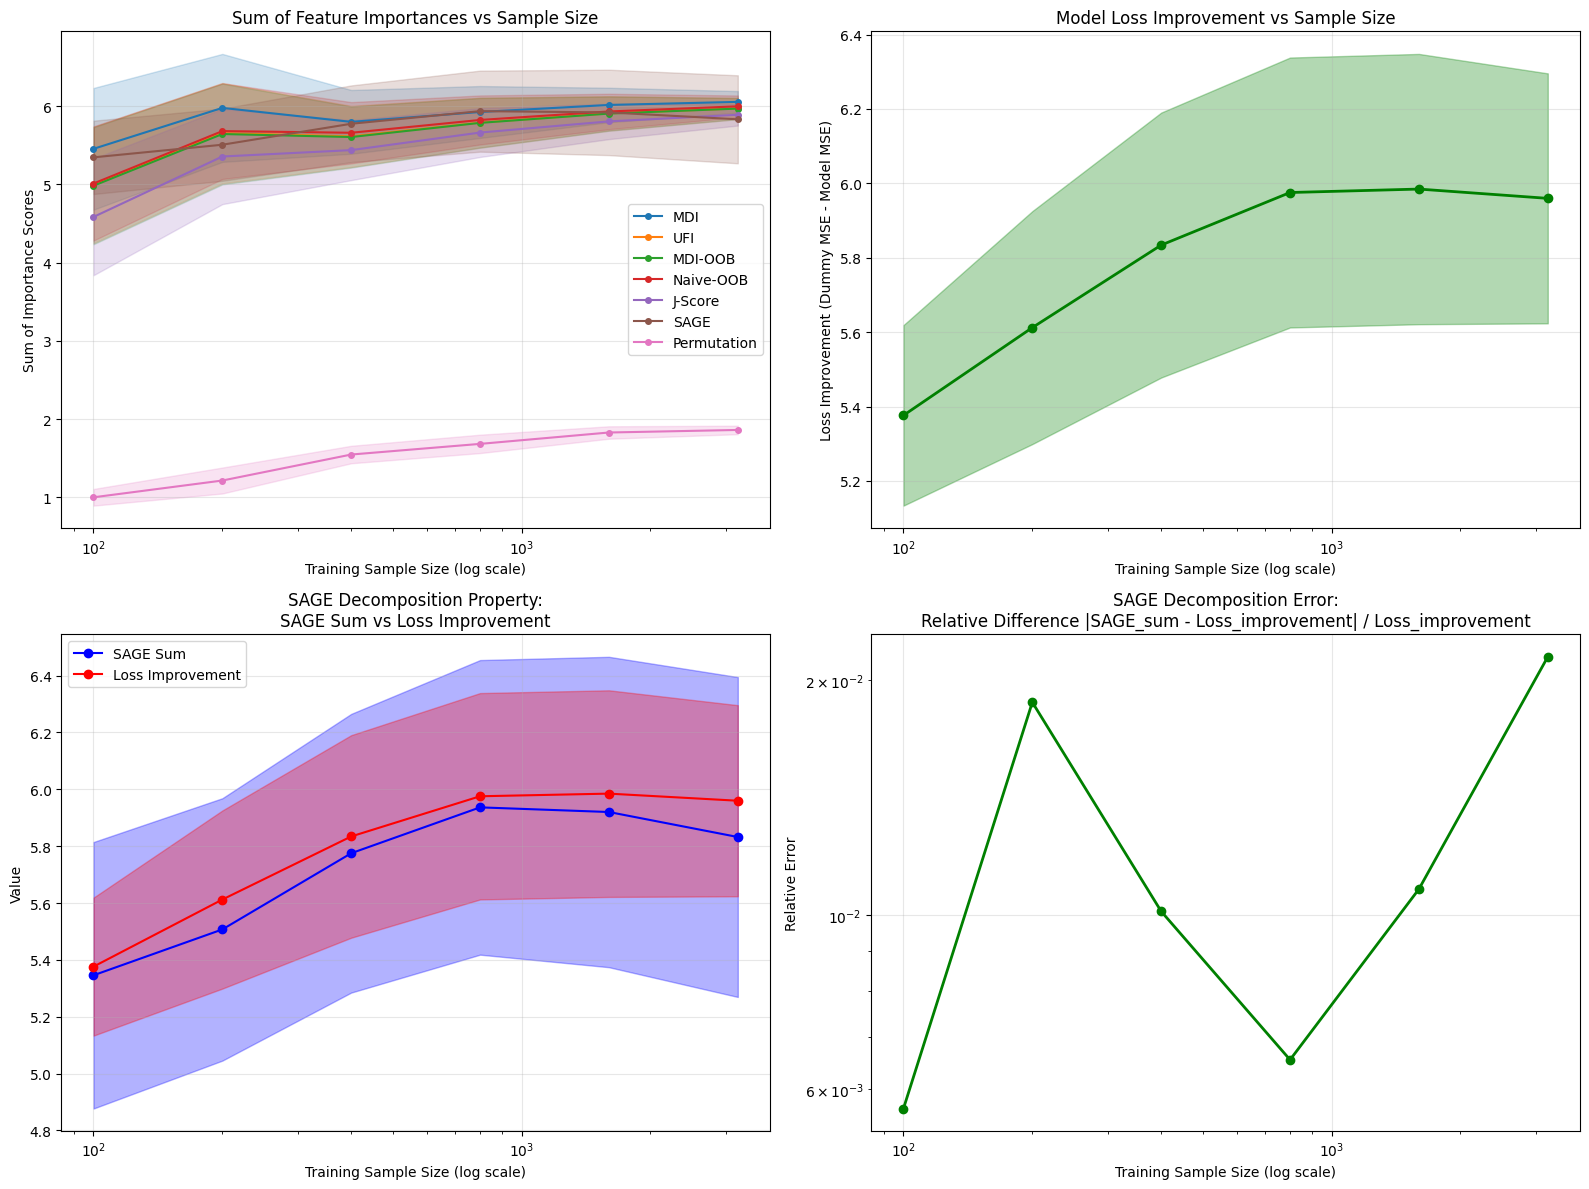

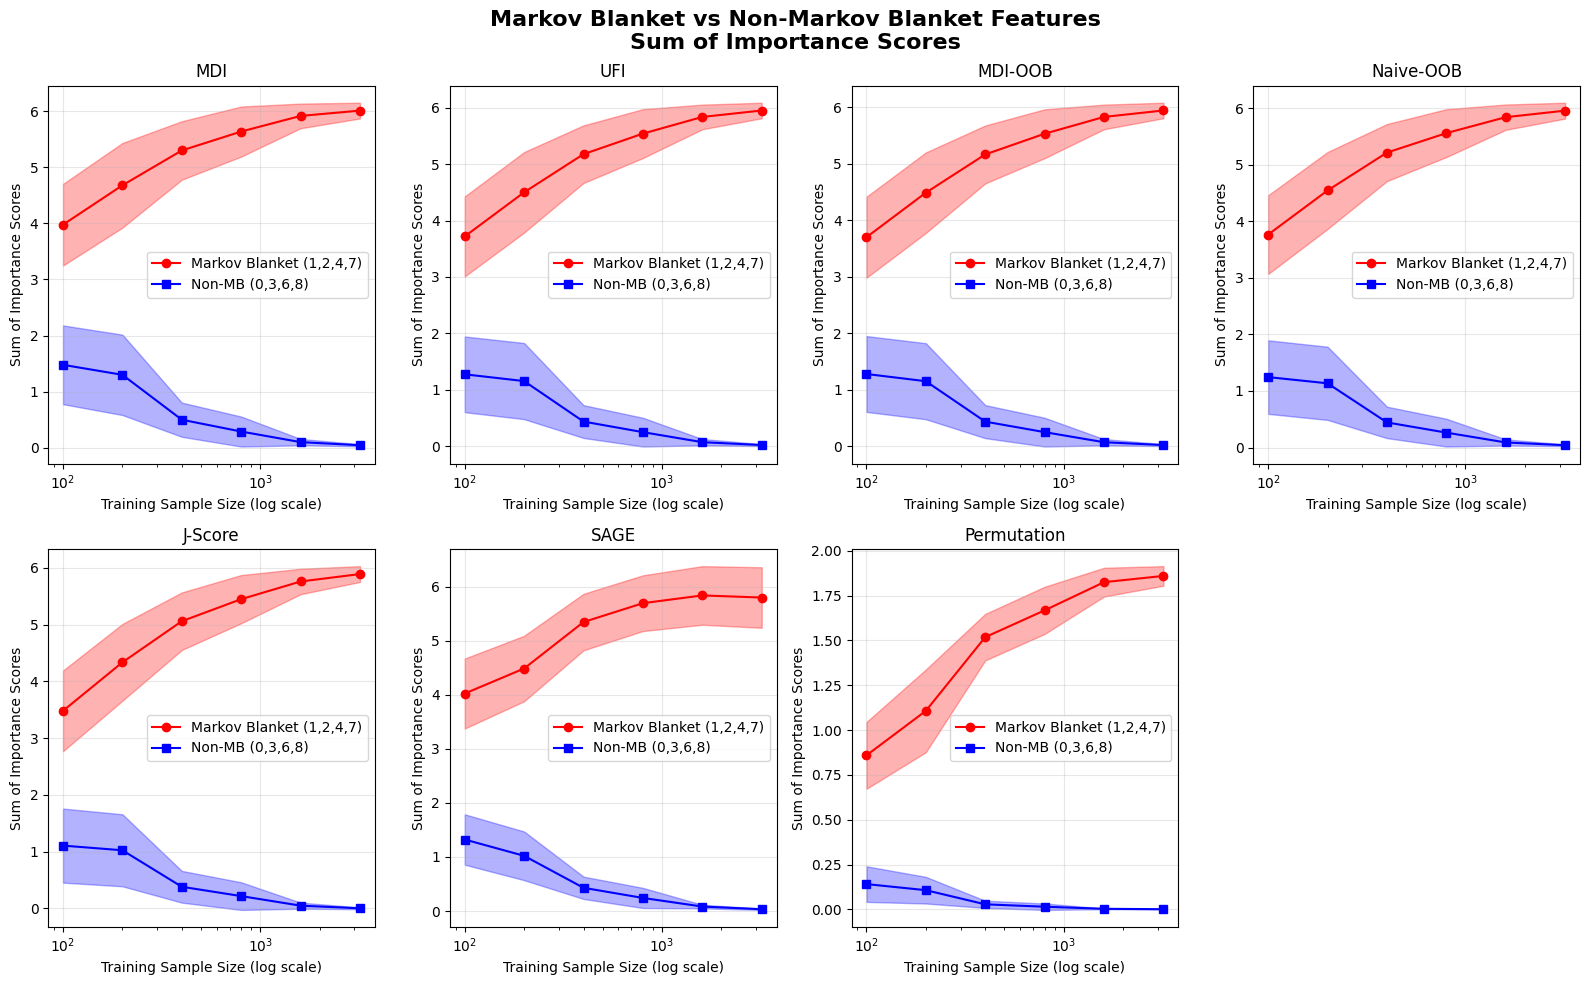

CONVERGENCE ANALYSIS
Mean importance scores by sample size (Markov Blanket features: 1,2,4,7)
----------------------------------------------------------------------------------------------------

MDI:
Sample Size | F0      | F1      | F2      | F3      | F4      | F6      | F7      | F8     | Sum
------------|---------|---------|---------|---------|---------|---------|---------|--------|-----
        100 |  0.2177 |  0.3669 |  3.3963 |  0.0105 |  0.0158 |  1.2392 |  0.1967 |  0.0115 |  5.4546
        200 |  0.1299 |  0.5650 |  4.0130 |  0.0082 |  0.0093 |  1.1522 |  0.0901 |  0.0103 |  5.9780
        400 |  0.0259 |  0.7261 |  4.5243 |  0.0053 |  0.0067 |  0.4636 |  0.0415 |  0.0058 |  5.7992
        800 |  0.0146 |  0.8523 |  4.7527 |  0.0048 |  0.0047 |  0.2650 |  0.0260 |  0.0055 |  5.9256
       1600 |  0.0086 |  0.9056 |  4.9931 |  0.0048 |  0.0041 |  0.0827 |  0.0113 |  0.0052 |  6.0154
       3200 |  0.0067 |  0.9521 |  5.0440 |  0.0047 |  0.0041 |  0.0294 |  0.0086 |  0.0052 | 

In [5]:

# Create plots
fig1, fig2 = plot_asymptotic_behavior(results)

# Show individual feature evolution
fig1.suptitle('Feature Importance Evolution with Sample Size\n(Red: Markov Blanket Features)', 
              fontsize=16, fontweight='bold', y=0.98)
plt.show()

# Show summary plots
fig2.suptitle('Summary: Convergence and SAGE Decomposition Analysis', 
              fontsize=16, fontweight='bold', y=0.98)
plt.show()

# Create Markov blanket focused plot
fig3 = plot_markov_blanket_focus(results)
plt.show()

# Print summary table
create_convergence_summary_table(results)

# Additional analysis: Convergence rates
print(f"\n" + "=" * 100)
print("CONVERGENCE RATE ANALYSIS")
print("-" * 50)

for method, method_name in zip(['mdi', 'ufi', 'mdi_oob', 'j_score', 'sage', 'permut'], 
                              ['MDI', 'UFI', 'MDI-OOB', 'J-Score', 'SAGE', 'Permutation']):
    print(f"\n{method_name}:")
    
    # Check if Markov blanket importance is increasing and non-MB is decreasing
    mb_trend = []
    non_mb_trend = []
    
    for sample_size in sample_sizes:
        mb_scores = []
        non_mb_scores = []
        
        for sim_result in results[method][sample_size]:
            mb_score = np.sum([sim_result[idx] for idx in [1, 2, 4, 6]])  # MB features
            non_mb_score = np.sum([sim_result[idx] for idx in [0, 3, 5]])  # Non-MB features
            mb_scores.append(mb_score)
            non_mb_scores.append(non_mb_score)
        
        mb_trend.append(np.mean(mb_scores))
        non_mb_trend.append(np.mean(non_mb_scores))
    
    # Calculate trend slopes (simple linear fit)
    mb_slope = np.polyfit(sample_sizes, mb_trend, 1)[0]
    non_mb_slope = np.polyfit(sample_sizes, non_mb_trend, 1)[0]
    
    print(f"  Markov Blanket trend slope: {mb_slope:8.6f}")
    print(f"  Non-MB trend slope:         {non_mb_slope:8.6f}")
    print(f"  Separation improving:       {'YES' if mb_slope > 0 and non_mb_slope <= 0 else 'NO'}")